<a href="https://colab.research.google.com/github/TakashiSato/colaboratory/blob/master/NonLinearOptimalControl/Algorithm2_5_SequentialQuadraticProgrammingMehod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import numpy as np
import sympy
from sympy import *
import cvxopt as cvx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def custom_latex_printer(expr, **options):
    from IPython.display import Math, HTML
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-AMS_CHTML"
    javascript(content="""window.MathJax = {
        tex2jax: {
            inlineMath: [ ['$','$'] ],
            processEscapes: true
        }
        };""")
    javascript(url=url)
    return latex(expr, **options)
init_printing(use_latex="mathjax", latex_printer=custom_latex_printer)

## Robot Arm Class Definition

In [3]:
class DHParameter():
  def __init__(self, link_size):
    self.link_size = link_size
    self.a  = sympy.zeros(self.link_size, 1)
    self.alpha  = sympy.zeros(self.link_size, 1)
    self.d = sympy.zeros(self.link_size, 1)
    self.theta = sympy.zeros(self.link_size, 1)
    for i in range(self.link_size):
      self.a[i], self.alpha[i], self.d[i], self.theta[i] = sympy.var(['a_'+str(i), 'alpha_'+str(i), 'd_' + str(i+1), 'theta_'+str(i+1)])

  def get_symbols(self):
      return self.a, self.alpha, self.d, self.theta

class RobotArm():
  def __init__(self, joint_size):
    self.joint_size = joint_size
    self.link_size = joint_size + 1
    self.limits = {}
    # create symbols
    self.dh = DHParameter(self.link_size)
    a, alpha, d, theta = self.dh.get_symbols()

    # create HT-matrix
    self.T_i = []
    self.T_base = []
    for i in range(self.link_size):
      T = Matrix([[cos(theta[i]), -sin(theta[i]), 0, a[i]], [cos(alpha[i])*sin(theta[i]), cos(alpha[i])*cos(theta[i]), -sin(alpha[i]), -d[i]*sin(alpha[i])], [sin(alpha[i])*sin(theta[i]), sin(alpha[i])*cos(theta[i]), cos(alpha[i]), d[i]*cos(alpha[i])],[0,0,0,1]])
      self.T_i.append(T)
      self.T_base.append(self.T_i[0] if i == 0  else self.T_base[i-1] * self.T_i[i])

  def get_dh_symbols(self):
    return self.dh.get_symbols()

  def set_dh_parameters(self, dh_params):
    for i in range(self.link_size):
        self.T_i[i] = self.T_i[i].subs(dh_params)
        self.T_i[i] = nsimplify(self.T_i[i], tolerance=1e-10,rational=True)
        self.T_base[i] = self.T_i[0] if i == 0  else self.T_base[i-1] * self.T_i[i]
        # self.T_base[i] = self.T_base[i].subs(dh_params)
    
    # compute jacobian
    self.jacobian = sympy.zeros(2, self.joint_size)
    for i in range(2):
      for j in range(self.joint_size):
        self.jacobian[i,j] = diff(self.T_base[-1][i,3], theta[j])

  def set_limits(self, limits):
    self.limits = limits
 
  def forward_kinematics(self, q):
    T_base = []
    if len(q) != self.joint_size:
      print('invalid joint length')
    np.append(q, 0)
    subs_dict = dict(zip(self.dh.theta, q))
    for i in range(self.link_size):
      T_base.append(self.T_base[i].subs(subs_dict))
    return T_base

  def draw(self, q, ax=None, coordinate='xy', style='-bo'):
      T_base = []
      T_base.append(sympy.eye(4,4))
      T_base.extend(self.forward_kinematics(q))
      if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
      for i in range(len(T_base)-1):
        X = [T_base[i][0,3], T_base[i+1][0,3]]
        Y = [T_base[i][1,3], T_base[i+1][1,3]]
        Z = [T_base[i][2,3], T_base[i+1][2,3]]
        if coordinate == 'xy':
          ax.plot(X, Y, style)
          ax.set_xlabel('x')
          ax.set_ylabel('y')
        elif coordinate == 'xz':
          ax.plot(X, Z, style)
          ax.set_xlabel('x')
          ax.set_ylabel('z')
        elif coordinate == 'yz':
          ax.plot(Y, Z, style)
          ax.set_xlabel('y')
          ax.set_ylabel('z')
      ax.plot(0, 0, 'kx', markersize=15)
      ax.set_aspect('equal', 'datalim')

In [4]:
def normalize_angle(angle):
  angle = angle % (2.0 * np.pi)
  if angle > np.pi:
    angle -= 2.0*np.pi
  elif angle <= -np.pi:
    angle += 2.0*np.pi
  return angle

def to_numpy_array(arr):
  return np.array(arr).astype(np.float64)

In [5]:
class OptimizationResult():
  def __init__(self):
    self.x_symbols = None
    self.f_symbols = None
    self.grad_symbols = None
    self.x_star = []
    self.x0_log = []
    self.eval_log = []

  def record_log(self, x0, eval):
    self.x0_log.append(x0)
    self.eval_log.append(eval)

  def set_result(self, f_symbols, grad_symbols, x_symbols, x_star):
    self.f_symbols = f_symbols
    self.grad_symbols = grad_symbols
    self.x_symbols = x_symbols
    self.x_star = np.array(x_star).astype(np.float64).reshape(1,-1)[0]

In [6]:
# 直線探索
def line_search(f_symbols, x_symbols, x0, s):
  alpha_value = np.linspace(0.01, 2*np.pi, 100000)
  
  alpha = sympy.symbols('alpha')
  x_temp_func  = sympy.lambdify(alpha, x0 + alpha * s, 'numpy')
  f = sympy.lambdify(x_symbols, f_symbols, 'numpy')

  x_temp = x_temp_func(alpha_value)
  eval_value = f(*x_temp)[0]
  min_index = np.argmin(eval_value)
  
  # print(min_index, alpha_value[min_index], eval_value[min_index])
  
  return alpha_value[min_index], eval_value[min_index]

In [7]:
# 最急降下法
def steepest_descent_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10):
  ret = OptimizationResult()

  grad_symbols = sympy.zeros(1, len(x_symbols))
  for i in range(len(x_symbols)):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])

  ret.record_log(x0, f_symbols.subs(list(zip(x_symbols, x0))))
  for i in range(max_iteration):
    grad =  grad_symbols.subs(list(zip(x_symbols, x0)))
    if grad.norm() < epsilon:
      break
    s = -grad.T
    alpha_star, eval_min =  line_search(f_symbols, x_symbols, x0, s)

    x0 = x0 + alpha_star * s
    for j in range(len(x0)):
      x0[j] = normalize_angle(x0[j])

    ret.record_log(x0, eval_min)

    if i % print_interval == 0:
      print(i, x0, eval_min, grad.norm())
  ret.set_result(f_symbols, grad_symbols, x_symbols, x0)     
  return ret

In [8]:
def conjugate_gradient_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10):
  ret = OptimizationResult()

  # grad_symbols = sympy.tensor.array.derive_by_array(f_symbols, x_symbols)
  grad_symbols = sympy.zeros(1, len(x_symbols))
  for i in range(len(x_symbols)):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])

  ret.record_log(x0, f_symbols.subs(list(zip(x_symbols, x0))))
  n = len(x_symbols)
  k = 0
  x_k = x0
  for i in range(max_iteration):
    if(k == 0):
      grad =  grad_symbols.subs(list(zip(x_symbols, x_k)))
      s_k = d_k = -grad.T
    else:
      s_k = s_kp1
      d_k = d_kp1

    if d_k.norm() < epsilon:
      break

    alpha_k, eval_min =  line_search(f_symbols, x_symbols, x_k, s_k)

    x_k = x_k + alpha_k * s_k
    for j in range(len(x_k)):
      x_k[j] = normalize_angle(x_k[j])

    if k < n-1:
      grad =  grad_symbols.subs(list(zip(x_symbols, x_k)))
      d_kp1 = -grad.T
      # beta_k = d_kp1 * (d_kp1 - d_k) / (d_k.norm() ** 2)
      beta_k = (d_kp1.norm() ** 2) / (d_k.norm() ** 2)
      s_kp1 = d_kp1 + beta_k * s_k
      k += 1
    else:
      k = 0
    ret.record_log(x_k, eval_min)

    if i % print_interval == 0:
      print(i, x_k, eval_min, d_kp1.norm())
  ret.set_result(f_symbols, grad_symbols, x_symbols, x_k)     
  return ret

In [9]:
def newton_raphson_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10):
  def  debug_print(x0, eval_value, grad):
      print('[{0}]\tx0={1}\tf={2},\tgrad={3},\tgrad_norm={4}'.format(
          i, np.round(np.array(x0).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(eval_value).astype(np.float64), 4),
          np.round(np.array(grad).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(grad.norm()).astype(np.float64), 4)))
      
  def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

  ret = OptimizationResult()
  n = len(x_symbols)

  grad_symbols = sympy.zeros(1, n)
  hessian_symbols = sympy.zeros(n, n)
  for i in range(n):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])
    for j in range(n):
      hessian_symbols[i,j] = diff(diff(f_symbols, x_symbols[i]), x_symbols[j])

  # use jacobian
  # grad_symbols = g.T * robot.jacobian
  # hessian_symbols = robot.jacobian.T * robot.jacobian
  
  h = sympy.lambdify(x_symbols, hessian_symbols, 'numpy')

  # 1) initial x0 is given by argument
  for i in range(max_iteration):
    # logging
    eval_value =  f_symbols.subs(list(zip(x_symbols, x0)))
    ret.record_log(x0, eval_value)

    # 2) stop when grad vector norm nearly equal 0
    grad =  grad_symbols.subs(list(zip(x_symbols, x0)))
    if grad.norm() < epsilon:
      break
    if i % print_interval == 0:
      debug_print(x0, eval_value, grad)

    # 3) compute delta x by usin eq.(2.29)
    hessian = hessian_symbols.subs(list(zip(x_symbols, x0)))
    H = hessian + sympy.eye(n, n) * 1e-9
    H_value = h(*(to_numpy_array(x0))).reshape(n, n)
    if not is_pos_def(H_value):
      print("Hessian is not positive definite matrix!")

    dx = -(H.inv() * grad.T)

    # check newton direction
    if (grad * dx)[0] > 0:
      print("Newton direction is not down direction!")
      # dx *= -1

    # 3.5) line search
    alpha, _ =  line_search(f_symbols, x_symbols, x0, dx)
    # alpha = 1.0

    # 4) compute x0 := x0 + alpha * dx -> back to step 2)
    x0 = x0 + alpha * dx
    for j in range(len(x0)):
      x0[j] = normalize_angle(x0[j])

  debug_print(x0, eval_value, grad)

  ret.set_result(f_symbols, grad_symbols, x_symbols, x0)     
  return ret

In [10]:
def quasi_newton_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10, solver='BFGS'):
  def  debug_print(x0, eval_value, grad):
      print('[{0}]\tx0={1}\tf={2},\tgrad={3},\tgrad_norm={4}'.format(
          i, np.round(np.array(x0).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(eval_value).astype(np.float64), 4),
          np.round(np.array(grad).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(grad.norm()).astype(np.float64), 4)))

  ret = OptimizationResult()
  n = len(x_symbols)

  grad_symbols = sympy.zeros(1, n)
  for i in range(n):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])
  # use jacobian
  # grad_symbols = g.T * robot.jacobian

  k = 0
  x_k = x0
  x_kp1 = x0
  I = sympy.eye(n, n)
  H_k = I

  for i in range(max_iteration):
    # logging
    eval_value =  f_symbols.subs(list(zip(x_symbols, x_k)))
    ret.record_log(x_k, eval_value)

    # 1) set initial x_k, g_k, H_k
    if k == 0:
      x_k = x_kp1
      g_k = grad_symbols.subs(list(zip(x_symbols, x_k)))
      H_k = I

    # 2) stop when gradient vector norm nearly equal 0
    if g_k.norm() < epsilon:
      break
    if i % print_interval == 0:
      debug_print(x_k, eval_value, g_k)

    # 3) compute delta_x by using eq.(2.30)
    delta_x = -H_k.inv() * g_k.T

    # 4) line search 
    alpha, _ =  line_search(f_symbols, x_symbols, x_k, delta_x)
    x_kp1 = x_k + alpha * delta_x
    for j in range(n):
      x_kp1[j] = normalize_angle(x_kp1[j]) 

    # 4.5) reset k := 0
    if k == n-1:
      k = 0
      continue

    # 5) compute s_k and y_k
    g_kp1 =  grad_symbols.subs(list(zip(x_symbols, x_kp1)))
    y_k = g_kp1.T - g_k.T
    s_k = x_kp1 - x_k

    # 6) compute H_{k+1} by using eq.(2.33) or (2.34)
    # BFGS method
    if solver is 'BFGS':
      H_k = H_k + (y_k * y_k.T) / (y_k.T * s_k)[0] - (H_k * s_k * s_k.T * H_k) / (s_k.T * H_k * s_k)[0]
    elif solver is 'DFP':  
      H_k = H_k + (y_k * y_k.T) / (y_k.T * s_k)[0] - (I - (y_k * s_k.T) / (y_k.T * s_k)[0]) * H_k * ((I - s_k * y_k.T) / (s_k.T * y_k)[0])
    else:
      print('invalid solver is given!')
      return None

    # update k := k+1
    k += 1
    x_k = x_kp1
    g_k = g_kp1

  debug_print(x_k, eval_value, g_k)

  ret.set_result(f_symbols, grad_symbols, x_symbols, x_k)     
  return ret

In [11]:
def penalty_method(solver, robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1, min_r=1, max_r=1e+3, step=100, penalty_value_epsilon=1e-4, exargs={}):
  # constraints: joint angle limit
  g = []
  for q, limit in robot.limits.items():
    # print(q, limit)
    g.append(Piecewise( (limit[0] - q, q < limit[0]), (0.0, True) )) # lower limit condition: qmin <= q -> qmin - q <= 0
    g.append(Piecewise( (q - limit[1], q > limit[1]), (0.0, True) )) # upper limit condition: q <= qmax -> q - qmax <= 0
  penalty_symbols = sum([gi**2 for gi in g])

  for i, r in enumerate(np.linspace(min_r, max_r, step)):
    print("##########################################")
    print('Penalty method loop[%d/%d]: r = %f' % (i+1, step, r))
    fr_symbols = f_symbols + r * penalty_symbols
    result = solver(f_symbols=fr_symbols, x_symbols=x_symbols, x0=x0, epsilon=epsilon, max_iteration=max_iteration, print_interval=print_interval, **exargs)    
    penalty_value = penalty_symbols.subs(list(zip(x_symbols, result.x_star)))
    x0 = Matrix(result.x_star)
    print("    - Optimal solution: ", np.degrees(result.x_star))
    print("    - Eval value: ", result.eval_log[-1])
    print("    - Penalty value: ", r*penalty_value)
    if penalty_value < penalty_value_epsilon:
      break
  print("##########################################")
  return result

In [12]:
def barrier_method(solver, robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1, min_r=1, max_r=1e+3, step=100, barrier_value_epsilon=1e-4, exargs={}):
  # constraints: joint angle limit
  g = []
  for i, (q, limit) in enumerate(robot.limits.items()):
    # print(q, limit)
    g.append(limit[0] - q) # lower limit condition: qmin <= q -> qmin - q <= 0
    g.append(q - limit[1]) # upper limit condition: q <= qmax -> q - qmax <= 0
    
    # Barrier method requires x0 to be in the limit range
    if x0[i] < limit[0] or limit[1] < x0[i]:
      x0[i] = np.random.uniform(limit[0], limit[1])

  barrier_symbols = sum([1.0/(gi**2) for gi in g])  # B(x) = 1/g(x)^2

  for i, r in enumerate(np.linspace(min_r, max_r, step)):
    print("##########################################")
    print('Barrier method loop [%d/%d]: r = %f' % (i+1, step, r))
    fr_symbols = f_symbols + 1.0/ r * barrier_symbols
    result = solver(f_symbols=fr_symbols, x_symbols=x_symbols, x0=x0, epsilon=epsilon, max_iteration=max_iteration, print_interval=print_interval, **exargs)    
    barrier_value = 1.0 / r * barrier_symbols.subs(list(zip(x_symbols, result.x_star)))
    x0 = Matrix(result.x_star)
    print("    - Optimal solution: ", np.degrees(result.x_star))
    print("    - Eval value: ", result.eval_log[-1])
    print("    - Barrier value: ", barrier_value)
    if barrier_value < barrier_value_epsilon:
      break
  print("##########################################")
  return result

In [13]:
def multiplier_method(solver, robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1, r_value=1e+3, h_value_epsilon=1e-4, exargs={}):
  # constraints h(x) = 0
  h_list = []
  h_list.append(x_symbols[2] + np.pi/2.0)    # h_1(x): theta[2] = -pi/2 -> theta[-1] + pi/2 = 0
  h_list.append(x_symbols[-1] - np.pi/2.0)  # h_2(x): theta[-1] = pi/2 -> theta[-1] - pi/2 = 0
  h = sympy.Matrix(h_list)

  r_symbol = sympy.var(['r'])
  mu_symbols = sympy.zeros(len(h), 1)
  for i in range(len(h)):
    mu_symbols[i] = sympy.var(['mu_'+str(i)])

  Lr_symbols = Matrix([f_symbols]) + mu_symbols.T * h + Matrix(r_symbol)/2 * h.T * h

  mu_k = sympy.zeros(len(h), 1)
  for i in range(max_iteration):
    print("##########################################")
    print('Multiplier method loop [%d/%d]: r = %f' % (i+1, max_iteration, r_value))
    Lr_k = Lr_symbols.subs([(r, r_value)])
    Lr_k = Lr_k.subs(list(zip(mu_symbols, mu_k)))
    result = solver(f_symbols=Lr_k[0], x_symbols=x_symbols, x0=x0, epsilon=epsilon, max_iteration=max_iteration, print_interval=print_interval, **exargs) 
    h_k =  h.subs(list(zip(x_symbols, result.x_star)))
    print("    - Optimal solution: ", np.degrees(result.x_star))
    print("    - Eval value: ", result.eval_log[-1])
    print("    - h value: ", h_k[0])
    if h_k[0] < h_value_epsilon:
      break
    mu_k = mu_k + r_value * h_k
    x0 = Matrix(result.x_star)
  print("##########################################")
  return result

## 具体値計算

In [14]:
# create robot arm
# joint_size = 2
# robot = RobotArm(joint_size)
# a, alpha, d, theta = robot.get_dh_symbols()
# robot.set_dh_parameters({
#     a[0]: 0,   alpha[0]: 0, d[0]: 0,
#     a[1]: 1.0, alpha[1]: 0, d[1]: 0,
#     a[2]: 1.0, alpha[2]: 0, d[2]: 0, theta[2]: 0,
# })
# robot.set_limits({
#     theta[0]: [0./180.*np.pi, 160./180.*np.pi],
#     theta[1]: [0./180.*np.pi, 160./180.*np.pi],   
# })

# joint_size = 3
# robot = RobotArm(joint_size)
# a, alpha, d, theta = robot.get_dh_symbols()
# robot.set_dh_parameters({
#     a[0]: 0,   alpha[0]: 0, d[0]: 0,
#     a[1]: 1.0, alpha[1]: 0, d[1]: 0,
#     a[2]: 1.0, alpha[2]: 0, d[2]: 0,
#     a[3]: 1.0, alpha[3]: 0, d[3]: 0, theta[3]: 0,
# })
# robot.set_limits({
#     theta[0]: [-160./180.*np.pi, 160./180.*np.pi],
#     theta[1]: [-90./180.*np.pi, 90./180.*np.pi],
#     theta[2]: [-90./180.*np.pi, 90./180.*np.pi],   
# })

joint_size = 5
robot = RobotArm(joint_size)
a, alpha, d, theta = robot.get_dh_symbols()
robot.set_dh_parameters({
    a[0]: 0,   alpha[0]: 0, d[0]: 0,
    a[1]: 1.0, alpha[1]: 0, d[1]: 0,
    a[2]: 1.0, alpha[2]: 0, d[2]: 0,
    a[3]: 1.0, alpha[3]: 0, d[3]: 0,
    a[4]: 1.0, alpha[4]: 0, d[4]: 0,
    a[5]: 1.0, alpha[5]: 0, d[5]: 0, theta[5]: 0,
})
robot.set_limits({
    theta[0]: [-160./180.*np.pi, 160./180.*np.pi],
    theta[1]: [-120./180.*np.pi, 120./180.*np.pi],
    theta[2]: [-120./180.*np.pi, 120./180.*np.pi],   
    theta[3]: [-120./180.*np.pi, 120./180.*np.pi],
    theta[4]: [-120./180.*np.pi, 120./180.*np.pi],
})

# joint_size = 7
# robot = RobotArm(joint_size)
# a, alpha, d, theta = robot.get_dh_symbols()
# robot.set_dh_parameters({
#     a[0]: 0, alpha[0]: 0,               d[0]: 0.215,
#     a[1]: 0, alpha[1]: -np.pi/2, d[1]: 0,
#     a[2]: 0, alpha[2]: +np.pi/2, d[2]: 0.300,
#     a[3]: 0, alpha[3]: -np.pi/2,  d[3]: 0,
#     a[4]: 0, alpha[4]: +np.pi/2, d[4]: 0.300,
#     a[5]: 0, alpha[5]: -np.pi/2,  d[5]: 0,
#     a[6]: 0, alpha[6]: +np.pi/2, d[6]: 0.170,
#     a[7]: 0, alpha[7]: 0,                d[7]: 0, theta[7]: 0,
# })

In [15]:
def plot_result(result):
  print("Optimal solution: ", np.degrees(result.x_star))
  fig, axes = plt.subplots(1, 4,  figsize=(32,8))

  # plot robot link movement
  ax = axes[0]
  for x_ in result.x0_log:
    robot.draw(x_, ax=ax, coordinate='xy', style='--bo')
  robot.draw(result.x0_log[0], ax=ax, style='-go')
  robot.draw(result.x_star, ax=ax, style='-ro')
  ax.plot(xd[0], xd[1], 'r*', markersize=14)

  # plot eval value log
  ax = axes[1]
  ax.plot(result.eval_log, '-bo')
  ax.set_xlabel('step')
  ax.set_ylabel('eval value')

  # plot gradient norm value log
  ax = axes[2]
  grad = sympy.lambdify(result.x_symbols, result.grad_symbols, 'numpy')
  x0_ = to_numpy_array(result.x0_log).transpose()
  grad_value = grad(*x0_)
  ax.plot(np.linalg.norm(grad_value, axis=1).reshape(-1), '-bo')
  ax.set_xlabel('step')
  ax.set_ylabel('gradient norm value')

  if len(result.x_symbols) > 2:
    return

  # plot gradient log
  ax = axes[3]
  t1 = t2 = np.linspace(-np.pi, np.pi, 100)
  f_func = sympy.lambdify(result.x_symbols, result.f_symbols, 'numpy') 
  grad_func = sympy.lambdify(result.x_symbols, result.grad_symbols, 'numpy') 
  X, Y = np.meshgrid(t1, t2)
  Z = f_func(X, Y)
  cont = ax.contour(X, Y, Z, 20)
  cont.clabel(fmt='%1.1f', fontsize=14)
  x0_ = []
  y0_ = []
  for x0 in result.x0_log:
    x0_.append(x0[0])
    y0_.append(x0[1])
  ax.plot(x0_, y0_, '--o')
  ax.plot(x0_[-1], y0_[-1], 'r*')
  ax.set_title('evaluation function')
  pp = ax.pcolormesh(X,Y,Z,cmap='cool')
  pp=fig.colorbar (pp, orientation="vertical")

  # plot gradient 3d
  # fig_3d, ax_3d = plt.subplots(1, 1,  figsize=(8,8))
  # ax = Axes3D(fig_3d)
  # # ax.plot_surface(X, Y, Z)
  # z0_ = np.array(result.eval_log)
  # ax.plot_wireframe(X, Y, Z, linewidth=0.1)
  # ax.contour(X, Y, Z)
  # ax.plot(x0_, y0_, z0_, '-ro', markersize=5)

In [16]:
  def compute_gradient(f_symbols, x_symbols):
    grad_symbols = sympy.zeros(1, len(x_symbols))
    for i in range(len(x_symbols)):
      grad_symbols[i] = diff(f_symbols, x_symbols[i])
    return grad_symbols

  def symbols_subs(f_symbols, x_symbols, x_values):
    return f_symbols.subs(list(zip(x_symbols, x_values)))

  def eval_lambdify_func(lambdify_func, x_k, lambda_k=None, s_k=None):
    X = x_k
    if lambda_k is not None:
      X = np.vstack([X, lambda_k])
    if s_k is not None:
      X = np.vstack([X, s_k])
    X = X.T[0]
    return lambdify_func(*X)

In [109]:
def active_set_method(delta_x0, H_k, f_grad_x_k, h_x_k, g_x_k, h_grad_x_k, g_grad_x_k, epsilon=1e-4, max_iteration=10, print_interval=10):
  # print("#" * 10)
  # print("ACTIVE SET")
  n = len(delta_x0)
  m_h = len(h_x_k)
  m_g = len(g_x_k)
  m = m_h + m_g

  alpha_symbol = sympy.var(['alpha'])

  left_mat = np.vstack([np.hstack([H_k, h_grad_x_k.T, g_grad_x_k.T]), np.hstack([h_grad_x_k, np.zeros([m_h, m])]), np.hstack([g_grad_x_k, np.zeros([m_g, m])])])
  right_vec = np.vstack([-f_grad_x_k.T, -h_x_k, -g_x_k])

  # 1) set initial solution
  delta_x_k = delta_x0

  # 2) check active inequarity conditions
  g = g_x_k + g_grad_x_k @ delta_x_k
  g_active = (np.isclose(np.zeros([m_g, 1]), g))

  for k in range(max_iteration):
    indices = np.vstack([np.array([[True]*(n+m_h)]).T, g_active])[:,0]
    # print('indices: ', indices)
    
    # 3) solve quadratic programming    
    C = left_mat[indices,:]
    C = C[:, indices]
    d = right_vec[indices,:]
    inv_C = np.linalg.inv(C)
    X =  inv_C @ d
    # print('X: ', X.T)

    delta_x_kp1 = X[0:n]
    mu_kp1 = X[n:n+m_h]
    lambda_kp1 = np.zeros([m_g,1])
    if (len(X) > n+m_h):
      # print('X_lambda: ', X[(n+m_h):])
      lambda_kp1[g_active[:,0]] = X[(n+m_h):]
    # print('lambda_kp1', lambda_kp1.T)

    # solution is executable
    # print('delta_x_kp1', delta_x_kp1.T)
    # print('delta_x_k', delta_x_k.T)
    # print('allclose', np.allclose(delta_x_kp1, delta_x_k))
    if np.allclose(delta_x_kp1, delta_x_k):
      # check KKT conditions
      lambda_cond = (lambda_kp1 < 0)
      if np.any(lambda_cond):   # lambda < 0 is exists
        # update not-active enequality condition
        min_lambda_index = np.argmin(lambda_kp1)
        g_active[min_lambda_index] = False
        # print('LAMBDA', lambda_kp1.T, min_lambda_index)
      else:   # all lambda >=0
        # optimal solution found!
        # print('#### optimal solution found! [loop: %d] ####' % k)
        # print('delta_x', delta_x_kp1.T)
        # print('mu: ', mu_kp1.T)
        # print('lambda: ', lambda_kp1.T)
        # print('g_active: ', g_active.T)
        return delta_x_kp1, mu_kp1, lambda_kp1, g_active
    # solution is not executable
    else:
      # line search
      delta_x_k_dash = Matrix([delta_x_k]) + Matrix(alpha_symbol) * Matrix([delta_x_kp1 - delta_x_k])
      g_kp1 = Matrix(g_x_k) + Matrix(g_grad_x_k) * delta_x_k_dash.T
      alpha_list = []
      for i, gi in enumerate(g_kp1):
        if g_active[i]:
          alpha = 1.1
        else:
          alpha = sympy.solve(gi)
          alpha = 1.1 if len(alpha) == 0 else alpha[0]
          if alpha < 0.0 or alpha > 1.0:
            alpha = 1.1
        alpha_list.append(to_numpy_array(alpha))
      alpha_list = np.array(alpha_list)
      if np.any(alpha_list <= 1.0):
        min_index = np.argmin(alpha_list)
        min_alpha = alpha_list[min_index]
        g_active[min_index] = True
        delta_x_kp1 = delta_x_k + min_alpha * (delta_x_kp1 - delta_x_k)
        # print('alpha', alpha_list, min_index)

    delta_x_k = delta_x_kp1
    mu_k = mu_kp1
    lambda_k = lambda_kp1
    # print("#### ", k)
    # print('delta_x', delta_x_k.T)
    # print('mu: ', mu_k.T)
    # print('lambda: ', lambda_k.T)
    # print('g_active: ', g_active.T)
  print("##########")
  print('active set method soulution not found!')
  return delta_x_kp1, mu_kp1, lambda_kp1, g_active

In [173]:
def sequential_quadratic_programming_method(robot, f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10, solver='BFGS'):
  ret = OptimizationResult()

  def compute_gradient(f_symbols, x_symbols):
    grad_symbols = sympy.zeros(1, len(x_symbols))
    for i in range(len(x_symbols)):
      grad_symbols[i] = diff(f_symbols, x_symbols[i])
    return grad_symbols

  def symbols_subs(f_symbols, x_symbols, x_values):
    return f_symbols.subs(list(zip(x_symbols, x_values)))

  def eval_lambdify_func(lambdify_func, x_k, lambda_k=None, s_k=None):
    X = x_k
    if lambda_k is not None:
      X = np.vstack([X, lambda_k])
    if s_k is not None:
      X = np.vstack([X, s_k])
    X = X.T[0]
    return lambdify_func(*X)

  def debug_print(x_k, mu_k, lambda_k, eval_value, delta_x_k):
    print('[{0}]\tx_k={1}\tmu_k={2}\tlambda={3}\teval={4}\tdelta_x_k={5}'.format(
    i, 
    np.round(np.array(x_k).astype(np.float64).reshape(1,-1)[0],4),
    np.round(np.array(mu_k).astype(np.float64).reshape(1,-1)[0], 4),
    np.round(np.array(lambda_k).astype(np.float64).reshape(1,-1)[0],4),
    np.round(np.array(eval_value).astype(np.float64).reshape(1,-1)[0],4),
    np.round(np.array(delta_x_k).astype(np.float64).reshape(1,-1)[0],4)))

  # Inequality constraints with slack varoable (g'(x) = g(x)-s = 0, g(x) <= 0, s >= 0) : joint angle limit
  slack_symbols = sympy.zeros(len(robot.limits) * 2, 1)  # slack variables
  for i in range(len(slack_symbols)):
    slack_symbols[i] = sympy.var(['s_' + str(i)])
  g_list = []
  g_pw_list = []
  for i, (q, limit) in enumerate(robot.limits.items()):
    g_list.append(limit[0] - q - slack_symbols[i*2]) # lower limit condition: qmin <= q -> qmin - q <= 0
    g_list.append(q - limit[1] - slack_symbols[i*2+1]) # upper limit condition: q <= qmax -> q - qmax <= 0
    g_pw_list.append(Piecewise( (limit[0] - q, q < limit[0]), (0.0, True) )) # lower limit condition: qmin <= q -> qmin - q <= 0
    g_pw_list.append(Piecewise( (q - limit[1], q > limit[1]), (0.0, True) )) # upper limit condition: q <= qmax -> q - qmax <= 0
  g_symbols = sympy.Matrix(g_list)
  m_g = len(g_symbols)

  # Equality constraints(h(x) = 0)
  h_list = []
  h_list.append(x_symbols[2] + np.pi/2.0)    # h_1(x): theta[2] = -pi/2 -> theta[2] + pi/2 = 0
  h_list.append(x_symbols[-1] - np.pi/2.0)  # h_2(x): theta[-1] = pi/2 -> theta[-1] - pi/2 = 0
  h_symbols = sympy.Matrix(h_list)
  m_h = len(h_symbols)

  # penalty function (for line search)
  r = 100
  p_list = []
  for q, limit in robot.limits.items():
    p_list.append(Piecewise( (limit[0] - q, q < limit[0]), (0.0, True) )) # lower limit condition: qmin <= q -> qmin - q <= 0
    p_list.append(Piecewise( (q - limit[1], q > limit[1]), (0.0, True) )) # upper limit condition: q <= qmax -> q - qmax <= 0
  penalty_symbols = r * Matrix([sum([p**2 for p in p_list]) + sum(np.abs(h_symbols))])
  f_symbols = Matrix([f_symbols])
  fr_symbols = f_symbols + penalty_symbols
  fr_func = sympy.lambdify(x_symbols, fr_symbols, 'numpy')
  
  # n: dim of input vars, m: dim of lagrangian coef (m_g: dim of inequality cond., m_h: dim of equality cond.)
  n = len(x0)
  m = m_g + m_h

  # Create symbols
  dx_symbols = sympy.zeros(n,1)  
  for i in range(n):
    dx_symbols[i] = sympy.var(['{\Delta}x_' + str(i)])
  lambda_symbols = sympy.zeros(m_g,1)
  dlambda_symbols = sympy.zeros(m_g,1)
  mu_symbols = sympy.zeros(m_h,1)
  dmu_symbols = sympy.zeros(m_h,1)
  for i in range(m_g):
    lambda_symbols[i] = sympy.var(['lambda_' + str(i)])
    dlambda_symbols[i] = sympy.var(['{\Delta}{\lambda}_' + str(i)])
  for i in range(m_h):
    mu_symbols[i] = sympy.var(['mu_' + str(i)])
    dmu_symbols[i] = sympy.var(['{\Delta}{\mu}_' + str(i)])

  # compute gradients
  f_grad_symbols = compute_gradient(f_symbols, x_symbols)  
  g_grad_symbols = sympy.zeros(m_g, n)
  h_grad_symbols = sympy.zeros(m_h, n)
  for i in range(m_g):
    g_grad_symbols[i,:] = compute_gradient(g_symbols[i], x_symbols)
  for i in range(m_h):
    h_grad_symbols[i,:] = compute_gradient(h_symbols[i], x_symbols)

  # Lagrangian definition
  L_symbols = f_symbols + lambda_symbols.T * g_symbols + mu_symbols.T * h_symbols
  L_grad_symbols = compute_gradient(L_symbols, x_symbols)

  # SQP eq.
  A_symbols = Matrix([h_grad_symbols, g_grad_symbols]).T  # n x m

  coef_symbols = Matrix([mu_symbols, lambda_symbols])
  dX_symbols = Matrix([dx_symbols, dmu_symbols, dlambda_symbols])
  X_symbols = Matrix([x_symbols, mu_symbols, lambda_symbols])
  X_kp1_symbols = Matrix([x_symbols+dx_symbols, mu_symbols+dmu_symbols, lambda_symbols+dlambda_symbols])
  d_upper = -(f_grad_symbols.T)# + A_symbols * coef_symbols)
  d_lower = -Matrix([h_symbols, g_symbols])
  d_symbols = Matrix([d_upper, d_lower])
  alpha_symbol = Matrix([sympy.var(['alpha'])])

  # lambdify for fast computation
  g_func = sympy.lambdify(Matrix([x_symbols, slack_symbols]), g_symbols, 'numpy')
  g_grad_func = sympy.lambdify(Matrix([x_symbols, slack_symbols]), g_grad_symbols, 'numpy')
  h_func = sympy.lambdify(x_symbols, h_symbols, 'numpy')
  h_grad_func = sympy.lambdify(x_symbols, h_grad_symbols, 'numpy')
  L_grad_func = sympy.lambdify(X_symbols, L_grad_symbols, 'numpy')
  A_func = sympy.lambdify(x_symbols, A_symbols, 'numpy')
  d_func = sympy.lambdify(Matrix([X_symbols, slack_symbols]), d_symbols, 'numpy')
  f_func = sympy.lambdify(x_symbols, f_symbols, 'numpy')
  f_grad_func = sympy.lambdify(x_symbols, f_grad_symbols, 'numpy')

  # set initial executable solution
  x0[2] = -np.pi/2.0
  x0[-1] = np.pi/2.0
  for i, (q, limit) in enumerate(robot.limits.items()):
    if x0[i] < limit[0] or limit[1] < x0[i]:
      x0[i] = np.random.uniform(limit[0], limit[1])

  k = 0
  x_k = to_numpy_array(x0)
  x_kp1 = x_k
  delta_x_k = np.zeros([n, 1])
  # lambda_k = np.zeros([m, 1])
  slack_zero = np.zeros([len(slack_symbols), 1])
  I = np.eye(n)
  O = np.zeros([m ,m])          # m x m
  H_k = I                       # n x n

  # check active inequarity conditions
  # g = eval_lambdify_func(g_func, x_k, None, slack_zero).T
  # g_active = (np.isclose(np.zeros([len(g), 1]), g))
  slack_k = np.ones([len(slack_symbols), 1])
  # slack_k[g_active.T] = 0

  for i in range(max_iteration):
    # 1) set initial x_k, H_k
    if k == 0:
      x_k = x_kp1
      H_k = I

    # logging
    eval_value = Matrix([eval_lambdify_func(f_func, x_k)])
    ret.record_log(Matrix([x_k]), eval_value)

    # 2) solve quadratic programming
    delta_x_k, mu_kp1, lambda_kp1, g_active = active_set_method(
        delta_x_k, H_k,
        eval_lambdify_func(f_grad_func, x_k),
        eval_lambdify_func(h_func, x_k),
        eval_lambdify_func(g_func, x_k, s_k=slack_zero),
        eval_lambdify_func(h_grad_func, x_k),
        eval_lambdify_func(g_grad_func, x_k, s_k=slack_zero)
    )
    slack_k  = np.ones([len(slack_symbols), 1])
    slack_k[g_active] = 0
    # return delta_x_k, mu_kp1, lambda_kp1

    # 3) stop when delta_x_k vector norm nearly equal 0
    if  np.linalg.norm(delta_x_k.T, ord=2) < epsilon:
      g = eval_lambdify_func(g_func, x_k, None, slack_zero).T
      h = eval_lambdify_func(h_func, x_k).T
      g_cond = (g < 0) | (np.isclose(np.zeros([len(g), 1]), g))
      h_cond = np.isclose(np.zeros([len(h), 1]), h)
      print('g_cond', g_cond)
      print('h_cond', h_cond)
      break

    # 4) compute x_kp1 = x_k + delta_x_k, lambda_kp1 = lambda_k + delta_lambda_k
    x_kp1 = x_k + delta_x_k

    # # 4.5) line search
    # def for_line_search(f_func, x_k, d_k, step=1e-3):
    #   min_f = 10000
    #   for alpha in np.linspace(1e-3, 1.0, 1000):
    #     x_value = x_k + alpha * d_k
    #     f_value = eval_lambdify_func(f_func, x_value)
    #     if f_value > min_f:
    #       print('min_alpha: ', alpha)
    #       return alpha, f_value
    #     min_f = f_value
    #   print('#### line_serach iteration max! ####')
    #   return alpha, f_value      

    # alpha, _ =  for_line_search(fr_func, x_k, delta_x_k)
    # x_kp1 = x_k + alpha * delta_x_k
    # # print('x_kp1: ', x_kp1)

    for j in range(n):
      x_kp1[j] = normalize_angle(x_kp1[j]) 

    if i % print_interval == 0:
      debug_print(x_kp1, mu_kp1, lambda_kp1, eval_value, delta_x_k)

    # check solution executability
    # g = eval_lambdify_func(g_func, x_kp1, None, slack_zero).T
    # h = eval_lambdify_func(h_func, x_kp1).T
    # g_cond = (g < 0) | (np.isclose(np.zeros([len(g), 1]), g))
    # h_cond = np.isclose(np.zeros([len(h), 1]), h)
    # print('x_kp1', np.degrees(x_kp1.T))
    # print('g_cond', g_cond)

    # 5) compute s_k and y_k
    mu_lambda = np.vstack([mu_kp1, lambda_kp1])
    L_grad_x_kp1 = Matrix([eval_lambdify_func(L_grad_func, x_kp1, mu_lambda)[0]])
    L_grad_x_k = Matrix([eval_lambdify_func(L_grad_func, x_k, mu_lambda)[0]])
    y_k = to_numpy_array(L_grad_x_kp1.T - L_grad_x_k.T)
    s_k = delta_x_k

    # 6) compute H_{k+1} by using eq.(2.33) or (2.34)
    # BFGS method
    if solver is 'BFGS':
       H_k = H_k + (y_k @ y_k.T) / (y_k.T @ s_k)[0] - (H_k @ s_k @ s_k.T @ H_k) / (s_k.T @ H_k @ s_k)[0]
    elif solver is 'DFP':  
      H_k = H_k + (y_k @ y_k.T) / (y_k.T @ s_k)[0] - (I - (y_k @ s_k.T) / (y_k.T @ s_k)[0]) @ H_k @ ((I - s_k @ y_k.T) / (s_k.T @ y_k)[0])
    else:
      print('invalid solver is given!')
      return None

    # # 4.5) reset k := 0
    # if k == n-1:
    #   k = 0
    #   continue

    # update k := k+1
    k += 1
    x_k = x_kp1
    mu_k = mu_kp1
    lambda_k = lambda_kp1

  debug_print(x_k, mu_k, lambda_k, eval_value, delta_x_k)

  ret.set_result(f_symbols, f_grad_symbols, x_symbols, x_k)     
  return ret

[0]	x_k=[ 2.5913  0.7521 -1.5708  1.6676  1.5708]	mu_k=[1.8883 0.7277]	lambda=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]	eval=[0.4984]	delta_x_k=[ 1.9588  2.7654 -0.      1.4113  0.    ]
[1]	x_k=[ 2.7925  2.0944 -1.5708  2.0944  1.5708]	mu_k=[3.094  2.8733]	lambda=[0.     7.6171 0.     6.1715 0.     0.     0.     6.7683 0.     0.    ]	eval=[7.6553]	delta_x_k=[0.2012 1.3423 0.     0.4268 0.    ]
[2]	x_k=[-2.1733  2.0944 -1.5708  1.0072  1.5708]	mu_k=[ 0.0368 -1.1601]	lambda=[0.     0.     0.     1.1349 0.     0.     0.     0.     0.     0.    ]	eval=[1.1641]	delta_x_k=[ 1.3174  0.     -0.     -1.0872 -0.    ]
##########
active set method soulution not found!
[3]	x_k=[-2.7925  1.8547 -1.5708  1.4142  1.5708]	mu_k=[-0.4379  0.2687]	lambda=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]	eval=[0.9241]	delta_x_k=[-0.6193 -0.2397 -0.      0.407   0.    ]
[4]	x_k=[-2.6849  1.9038 -1.5708  1.3351  1.5708]	mu_k=[-0.0639 -0.008 ]	lambda=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]	eval=[0.0465]	delta_x_k=[ 0.1077  0.049  -0.     -0.079

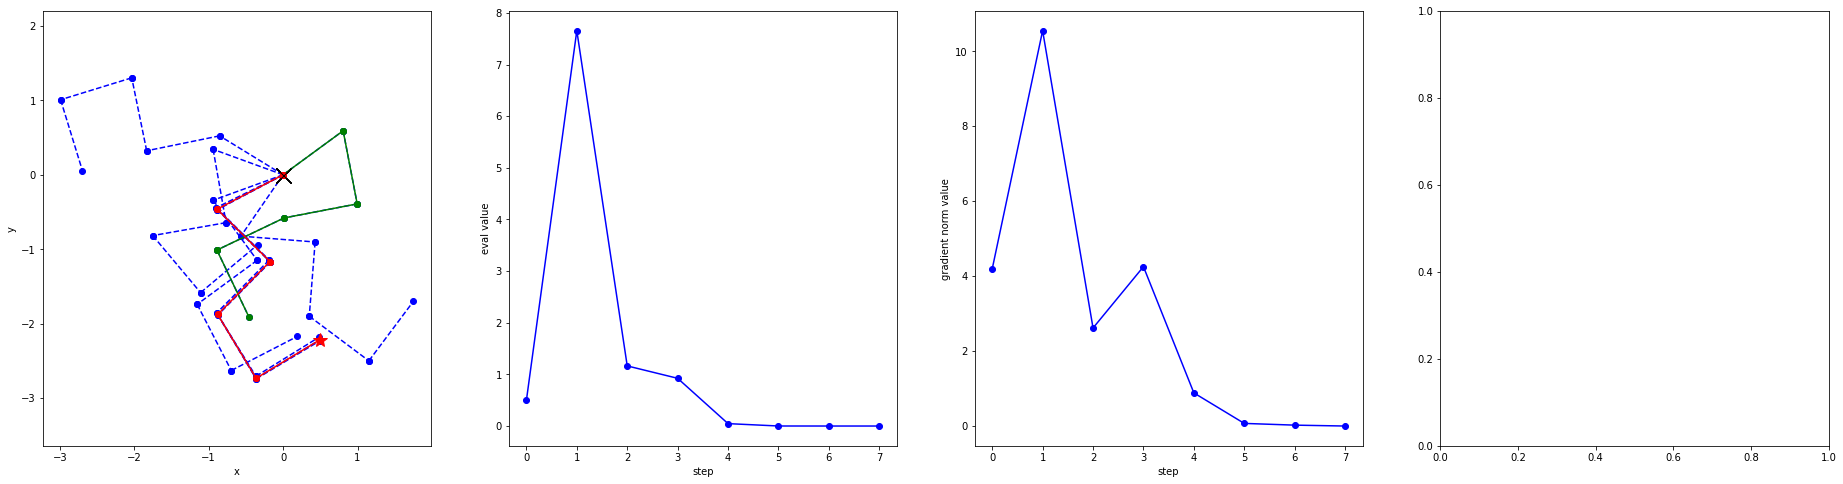

In [177]:
# problem settings
max_dist = robot.forward_kinematics([0.0]*joint_size)[-1][0,3]/2
x0 = Matrix(np.random.uniform(-np.pi, np.pi, joint_size))
t  = 2.0*np.pi*np.random.uniform(0,1,1) 
r = max_dist * np.sqrt(np.random.uniform(0,1,1))
xd = Matrix([r*np.cos(t), r*np.sin(t)])
ee_pose = robot.T_base[-1][0:2,3]

# evaluation function
e = Matrix(ee_pose - xd)
f_symbols = Matrix(1/2*e.T*e )[0]
x_symbols = Matrix(theta[0:-1])

# solve problem
# result = steepest_descent_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1)
# result = conjugate_gradient_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1)
# result = newton_raphson_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1)
# result = quasi_newton_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10, solver='DFP')
# result = quasi_newton_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10, solver='BFGS')
# plot_result(result)

# result = penalty_method(quasi_newton_method, robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10, exargs={'solver': 'BFGS'})
# result = barrier_method(quasi_newton_method, robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10, exargs={'solver': 'BFGS'})
# result = multiplier_method(quasi_newton_method, robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10, exargs={'solver': 'BFGS'})
# result = sequential_quadratic_programming_method(robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10, solver='BFGS')
result = sequential_quadratic_programming_method(robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1, solver='BFGS')
plot_result(result)

# result = sequential_quadratic_programming_method(quasi_newton_method, robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10, exargs={'solver': 'BFGS'})
# result

# manipulability = sqrt((robot.jacobian*robot.jacobian.T).det())
# print('manipulability: ', manipulability.subs(list(zip(x_symbols, result.x_star))))

In [125]:
alpha, _ =  line_search(a, b, Matrix(c), Matrix(d))

TypeError: ignored

In [ ]:
from line_profiler import LineProfiler

def func():
  result = sequential_quadratic_programming_method(robot, f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1, solver='BFGS')
  return result

prof = LineProfiler()
prof.add_function(func)
prof.add_function(sequential_quadratic_programming_method)
prof.runcall(func)
prof.print_stats()

In [ ]:
!pip install line_profiler